In [64]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras import layers
from keras import regularizers

import re

In [65]:
from keras import backend as K
K.clear_session()

In [66]:
physical_devices = tf.config.list_physical_devices()
CLASSES = 48
IMAGE_SIZE = 24

print(physical_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [67]:
tf.config.set_visible_devices(physical_devices[1], 'GPU')

## Building Dataset

### Attributes description

- a1 - face containing flag: (1-with face, 0-without face),
- a2 - image number in current class (person) beginning from 0,
- a3 - class (person) number beginning from 0,
- a4 - sex (0 - woman, 1 - man)
- a5 - race (0- white, 1 - negro, 2 - indian, ...)
- a6 - age (0 - baby, 1 - young, 2 - middle-age, 3 - old) 
- a7 - binokulars (0 - without, 1 - transparent, 2 - dark)
- a8 - emotional expression (not state!) (0 - sad, 1 - neutral, 2 - happy)

In [68]:
def read_file(filename):
  
  with open(filename, 'r') as file:
    lines = file.readlines()
    
    # Remove newLines
    for i, line in enumerate(lines):
      lines[i] = line.replace('\n', '')
    
    # We assume these are integers
    EXAMPLES_NR = int(lines[0])
    PIXELS_NR = int(lines[1])
    
    inputs = list()
    labels = np.zeros(EXAMPLES_NR, dtype=int)
    
    examples_raw = lines[2:EXAMPLES_NR+2]
    
    for i, example_raw in enumerate(examples_raw):
      # Split by spaces (treats multiple as one)
      tokens = re.split('\s+', example_raw)
      
      pixel_values = np.array(tokens[0:PIXELS_NR])
      attributes = tokens[PIXELS_NR:]
      
      pixel_values = np.array(pixel_values, dtype=float)
      pixel_values = pixel_values.reshape([IMAGE_SIZE, IMAGE_SIZE])
      
      inputs.append(pixel_values)
      labels[i] = int(attributes[2])
      
    inputs = np.array(inputs)
  return inputs, labels

In [69]:
# classes 0-15
X_0, y_0 = read_file('./data/x24x24.txt')
# classes 16-31
X_1, y_1 = read_file('./data/y24x24.txt')
# # classes 32-48
X_2, y_2 = read_file('./data/z24x24.txt')

print(len(X_0), len(y_0))
print(len(X_1), len(y_1))
print(len(X_2), len(y_2))

2321 2321
2208 2208
2306 2306


In [70]:
from sklearn.model_selection import train_test_split

# Concatenate train and test images
X = np.concatenate((X_0, X_1, X_2))
y = np.concatenate((y_0, y_1, y_2))
print(len(X), len(y))

N_TRAIN_EXAMPLES=int(len(X) * 0.8)
N_TEST_EXAMPLES=len(X) - N_TRAIN_EXAMPLES


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=N_TRAIN_EXAMPLES, test_size=N_TEST_EXAMPLES, random_state=1)

# One-Hot encoding
# Getting dummy variables
y_train_fixed = np.zeros((y_train.shape[0], CLASSES))
# y_valid_fixed = np.zeros((y_valid.shape[0], 10))
y_test_fixed = np.zeros((y_test.shape[0], CLASSES))

for i, value in enumerate(y_train):
  y_train_fixed[i][value] = 1
  
for i, value in enumerate(y_test):
  y_test_fixed[i][value] = 1

6835 6835


In [71]:
print(len(X_test))

1367


## Building a model

Testing LeNet-5 Architecture

In [72]:
from keras import Sequential, Input

conv_regularizer = regularizers.l2(l=0.0006)
dense_regularizer = regularizers.l2(l=0.01)

# conv_regularizer = regularizers.l2(l=0)
# dense_regularizer = regularizers.l2(l=0)

model = keras.Sequential(
  [
    Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
    layers.Conv2D(6, kernel_size=5, padding='same', activation='tanh', kernel_regularizer=conv_regularizer),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Dropout(0.2),
    layers.Conv2D(16, kernel_size=5, padding='same', activation='tanh', kernel_regularizer=conv_regularizer),
    layers.MaxPooling2D(pool_size=2, strides=2),
    
    layers.Dropout(0.35),
    layers.Conv2D(120, kernel_size=5, padding='same', activation='tanh', kernel_regularizer=conv_regularizer),
    
    layers.Flatten(),
    layers.Dropout(0.45),
    layers.Dense(84, activation='relu', kernel_regularizer=dense_regularizer),
    layers.Dense(CLASSES, activation='softmax'),
  ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 16)          0

In [73]:
from keras.optimizers import SGD, Adam
from keras.losses import categorical_crossentropy

# optimizer = Adam(learning_rate=0.00025)
optimizer = Adam(learning_rate=0.001)
# optimizer = SGD(learning_rate=0.01)

model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=["accuracy"])

## Training Preparation

In [74]:
CHECKPOINT_PATH = 'models/checkpoints/famous48_test_model_v2_best.keras'

In [75]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
  filepath=CHECKPOINT_PATH,
  save_weights_only=False,
  monitor='val_accuracy',
  mode='max',
  save_best_only=True,
)

In [76]:
%%time
batch_size = 200
epochs = 1000

# K.set_value(model.optimizer.learning_rate, 0.0005)

history = model.fit(
  X_train, y_train_fixed,
  batch_size=batch_size,
  epochs=epochs,
  validation_split=0.2,
  shuffle=True,
  callbacks=[model_checkpoint_callback]
)

Epoch 1/1000
22/22 [==============================] - 1s 27ms/step - loss: 4.8453 - accuracy: 0.0329 - val_loss: 4.2594 - val_accuracy: 0.0494
Epoch 2/1000
22/22 [==============================] - 0s 11ms/step - loss: 3.8935 - accuracy: 0.1246 - val_loss: 3.5470 - val_accuracy: 0.1600
Epoch 3/1000
22/22 [==============================] - 0s 11ms/step - loss: 3.2104 - accuracy: 0.2417 - val_loss: 2.8382 - val_accuracy: 0.3090
Epoch 4/1000
22/22 [==============================] - 0s 10ms/step - loss: 2.7613 - accuracy: 0.3450 - val_loss: 2.5660 - val_accuracy: 0.3766
Epoch 5/1000
22/22 [==============================] - 0s 12ms/step - loss: 2.4837 - accuracy: 0.4186 - val_loss: 2.3345 - val_accuracy: 0.4534
Epoch 6/1000
22/22 [==============================] - 0s 9ms/step - loss: 2.3550 - accuracy: 0.4556 - val_loss: 2.3233 - val_accuracy: 0.4424
Epoch 7/1000
22/22 [==============================] - 0s 11ms/step - loss: 2.2316 - accuracy: 0.4966 - val_loss: 2.0953 - val_accuracy: 0.5165


In [77]:
model.load_weights("models/checkpoints/famous48_test_model_v2_best.keras")
model.evaluate(X_test, y_test_fixed)

43/43 [==============================] - 0s 3ms/step - loss: 1.0623 - accuracy: 0.8376


[1.0623445510864258, 0.837600588798523]

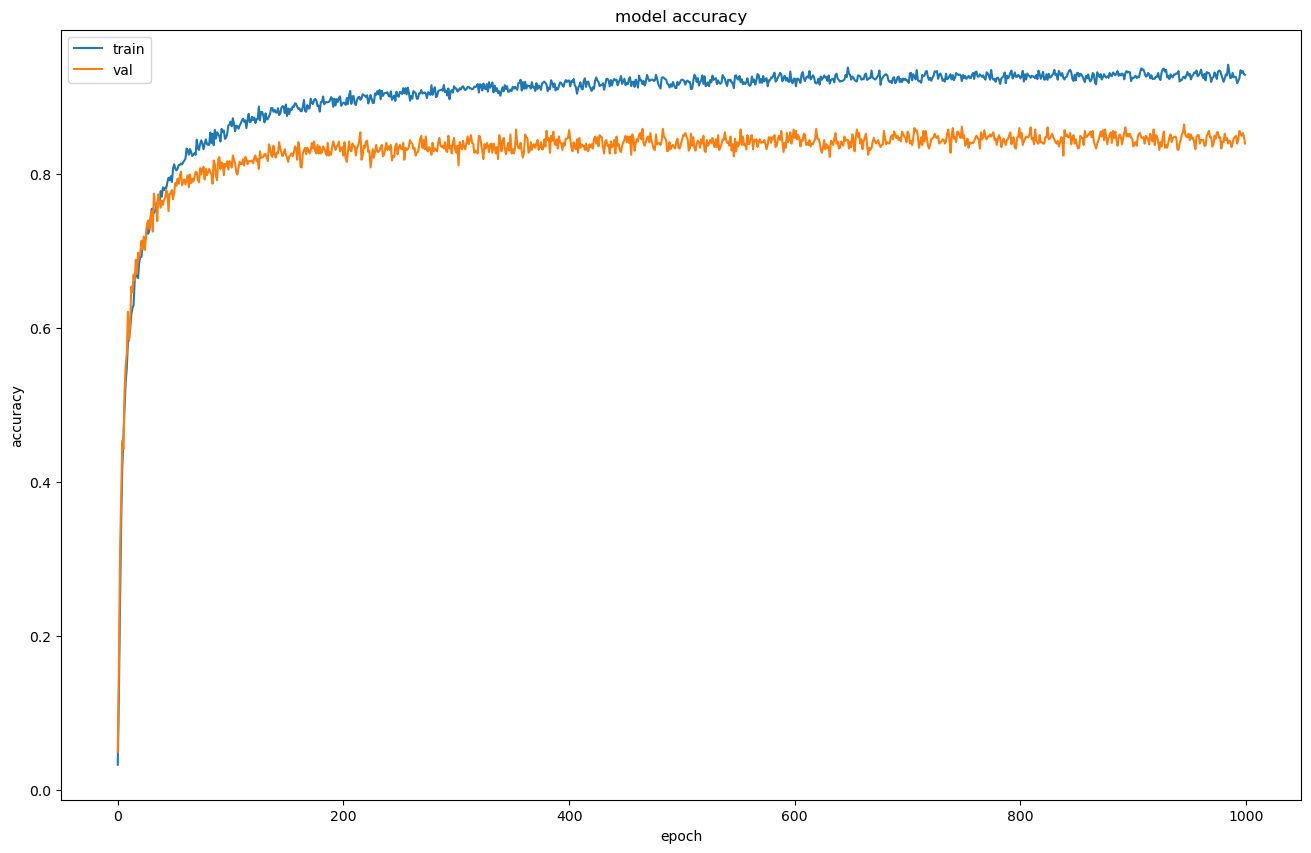

In [78]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()